# **Importing Libraries**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import (Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, 
                                     Dense, Flatten, Dropout)
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau


In [7]:

import cv2  
import torch  
import imghdr  
import torchvision  
from sklearn.utils import shuffle
from tensorflow.keras import layers 
from tensorflow.keras.models import Sequential  
from tensorflow.keras.optimizers import RMSprop 
from tensorflow.keras.applications import VGG16 
from tensorflow.keras.applications.vgg16 import preprocess_input 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy  
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout 

# **Importing Dataset**

In [8]:
#Importing our datasets
data_dir='/kaggle/input/downsyndrome/downSyndrome - Copy'

# **Building Data pipeline**

In [9]:
#Building Data pipeline
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 13512 files belonging to 2 classes.


In [10]:
data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [11]:
len(data)

423

# **resizing**

In [12]:
#resizing shape to none,224,224,3
import tensorflow as tf

# Assuming `dataset` is your original dataset with images of shape (256, 256, 3)
target_height, target_width = 224, 224

def resize_images(image, label):
    # Resize the image to the desired shape
    image = tf.image.resize(image, [target_height, target_width])
    return image, label

# Apply the resizing transformation to the dataset
data = data.map(resize_images)


In [13]:
data

<_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [14]:
len(data)

423

# **Converting the dataset to an iterator**

In [15]:
# Converting the dataset to an iterator
data_iterator = data.as_numpy_iterator()

# Acessing a batch from the Datapipeline
batch = data_iterator.next()
len(batch)

2

In [16]:
# Displaying the shape of the batch
batch[0].shape

(32, 224, 224, 3)

In [17]:
# Displaying the class labels
#Class 1 = Normal
#Class 0 = Down
batch[1]

array([1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 0], dtype=int32)

In [18]:
# Display the shape of the image batch
print(batch[0].shape)  # Should be (batch_size, height, width, channels)

# Display the labels
print(batch[1])  # Array of labels corresponding to the batch

(32, 224, 224, 3)
[1 0 1 0 0 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 0 0 1 0 1 1 0 1 0 1 0 0]


# **Converting the features array into a DataFrame**

In [19]:
# Converting the features array into a DataFrame
df_features = pd.DataFrame(batch[1])
print(df_features)

    0
0   1
1   0
2   1
3   0
4   0
5   1
6   0
7   0
8   0
9   0
10  0
11  0
12  0
13  1
14  1
15  0
16  0
17  1
18  1
19  1
20  0
21  0
22  1
23  0
24  1
25  1
26  0
27  1
28  0
29  1
30  0
31  0


# **Data visualization**

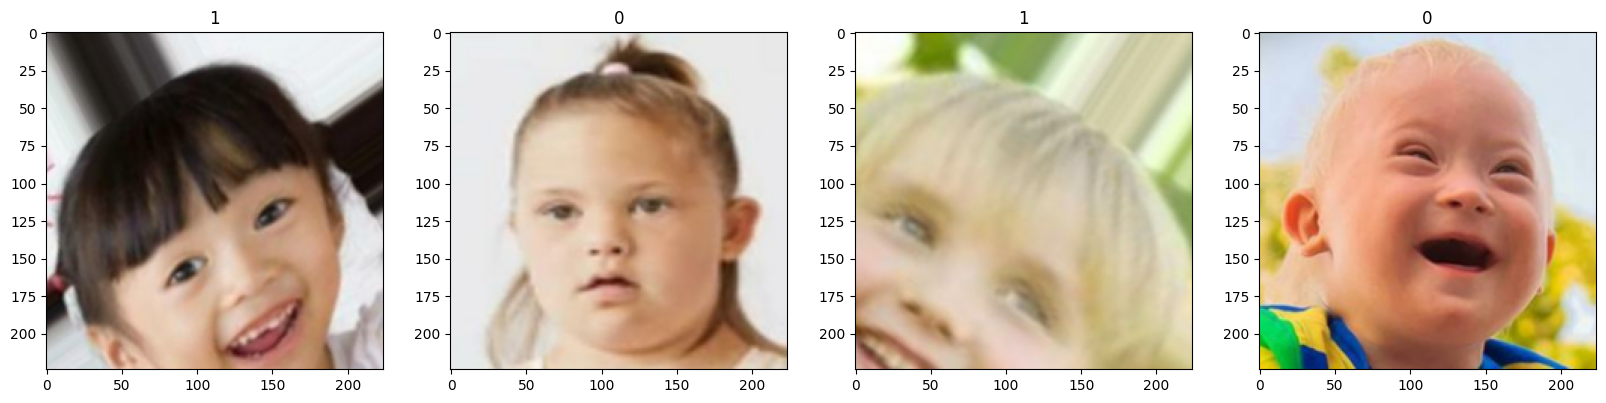

In [20]:
#Data visualization
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

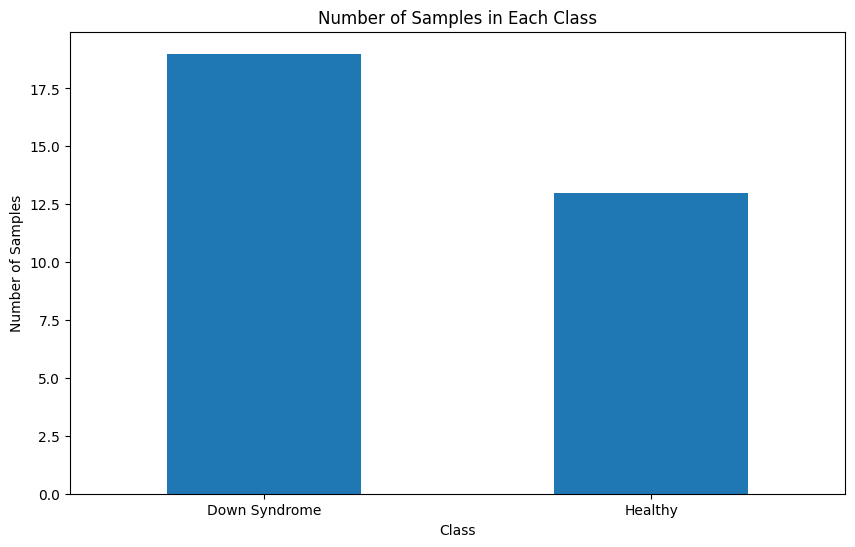

In [21]:
# Converting the features array into a DataFrame
df_features = pd.DataFrame(batch[1], columns=['Class'])

# Counting the number of samples in each class
class_counts = df_features['Class'].value_counts()

# Plotting the bar chart
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title('Number of Samples in Each Class')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(ticks=[0, 1], labels=['Down Syndrome', 'Healthy'], rotation=0)
plt.show()

In [22]:
class_counts

Class
0    19
1    13
Name: count, dtype: int64

# **Data scaling**

In [23]:
#Data Preprocessing

#Data scaling
data = data.map(lambda x, y: (x / 255.0, y))  # Scale images to [0, 1]

# Verifying scaling
print(data.as_numpy_iterator().next()[0].min())  # Should print 0.0

0.0


In [24]:
#Checking lenght of dataset
len(data)

423

# **Dataset splitting**

In [25]:
#Data splitting
train_size = int(len(data)*.7)
val_size = int(len(data)*.15)
test_size = int(len(data)*.15)

In [26]:
#checking our data size
train_size,val_size, test_size

(296, 63, 63)

In [27]:
#Assigning suitable variable names
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# **Creating Model**

In [28]:
#Creating Model¶
#I tried Different model architecture like VGG16, mobilenetv2,resnet50,Inceptionv3 but DenseNet works best

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

def get_model():
    densenet = DenseNet121(weights='imagenet',
                           include_top=False,
                           input_shape=(224, 224, 3)
                          )
    model = tf.keras.models.Sequential([
        densenet,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy']
                 )
    return model

spoofnet = get_model()
spoofnet.build(input_shape=(None, 224, 224, 3))  # Specify batch size as None for flexibility
spoofnet.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,564,865 (28.86 MB)

 Trainable params: 7,480,193 (28.53 MB)

 Non-trainable params: 84,672 (330.75 KB)

# **callbacks**

In [29]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger

checkpoint = ModelCheckpoint(filepath='spoffnet.keras',  # changed '.h5' to '.keras'
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='loss'  # changed 'val_loss' to 'loss'
                            )
reduce_lr = ReduceLROnPlateau(monitor='loss',  # changed 'val_loss' to 'loss'
                              factor=0.2, 
                              patience=3, 
                              verbose=1, 
                              min_delta=0.0001
                             )
csv_logger = CSVLogger('train.log')

callbacks = [checkpoint, reduce_lr, csv_logger]


# **Train the model**

In [30]:
# Fit the model with appropriate steps
hist = spoofnet.fit(
    train,
    validation_data=val,
    callbacks=callbacks,
    epochs=5
)

Epoch 1/5


I0000 00:00:1731160625.275650     133 service.cc:145] XLA service 0x797518002e50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731160625.275718     133 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1731160718.211875     133 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.7408 - loss: 0.5964
Epoch 1: loss improved from inf to 0.46510, saving model to spoffnet.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 229s 259ms/step - accuracy: 0.7410 - loss: 0.5959 - val_accuracy: 0.7743 - val_loss: 1.1222 - learning_rate: 0.0010
Epoch 2/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.8911 - loss: 0.2613
Epoch 2: loss improved from 0.46510 to 0.25311, saving model to spoffnet.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 69s 232ms/step - accuracy: 0.8911 - loss: 0.2612 - val_accuracy: 0.8547 - val_loss: 0.3390 - learning_rate: 0.0010
Epoch 3/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.9225 - loss: 0.1855
Epoch 3: loss improved from 0.25311 to 0.18984, saving model to spoffnet.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 68s 230ms/step - accuracy: 0.9225 - loss: 0.1855 - val_accuracy: 0.8849 - val_loss: 0.3233 - learning_rate: 0.0010
Epoch 4/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.9407 - loss: 0.1

# **Loss curve**

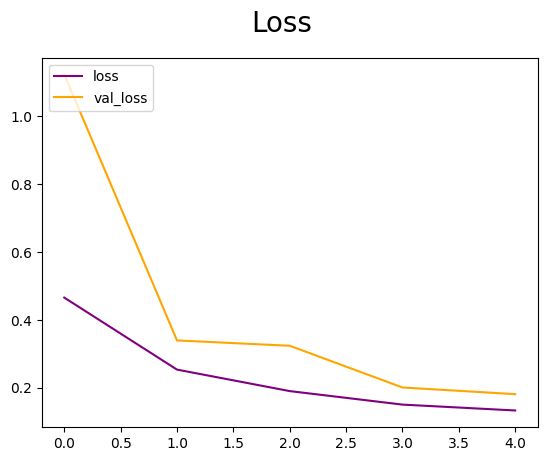

In [31]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='purple', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# **Accuracy curve**

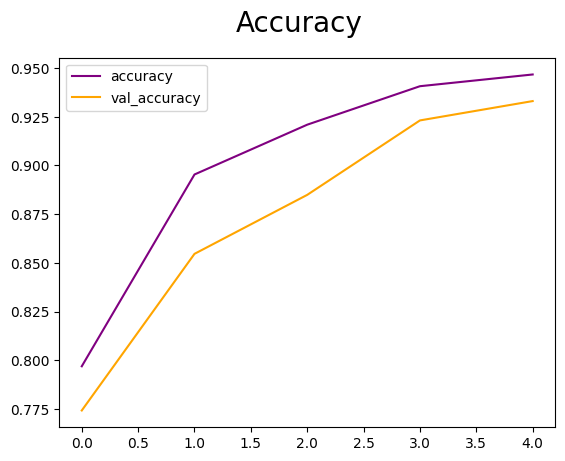

In [32]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='purple', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

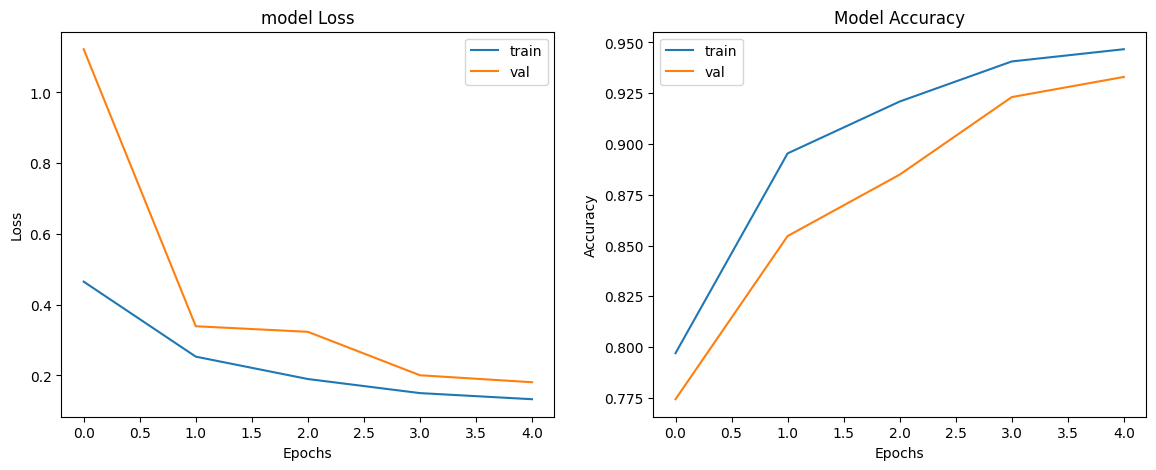

In [33]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val'])
plt.show()

# **Evaluate the model**

In [34]:
_, accu = spoofnet.evaluate(test)
print('Final Test Accuracy = {:.3f}%'.format(accu * 100))

63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - accuracy: 0.9154 - loss: 0.1970
Final Test Accuracy = 92.163%


# **Confussion Matrix and Model Performance Matrix**

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━

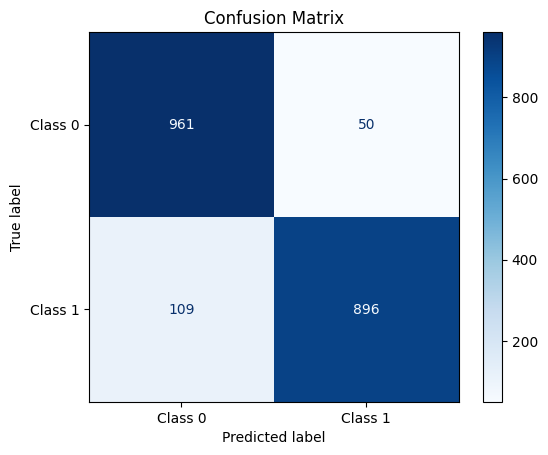

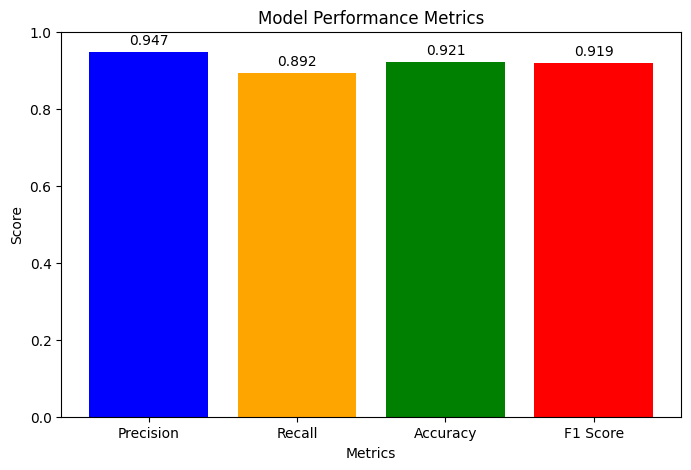

In [35]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Step 1: Predict labels for the test set
true_labels = []
pred_labels = []

for batch in test:  # Assuming `test` is your test dataset
    images, labels = batch
    predictions = spoofnet.predict(images)  # Replace with your model name if different
    true_labels.extend(labels.numpy())
    pred_labels.extend((predictions > 0.5).astype("int32").flatten())

# Step 2: Calculate precision, recall, accuracy, and F1 score
precision = precision_score(true_labels, pred_labels)
recall = recall_score(true_labels, pred_labels)
accuracy = accuracy_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels)

# Step 3: Create a DataFrame to display the metrics
metrics = {
    "Metric": ["Precision", "Recall", "Accuracy", "F1 Score"],
    "Score": [precision, recall, accuracy, f1]
}
metrics_df = pd.DataFrame(metrics)



# Step 5: Compute the confusion matrix and plot it
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Step 4: Plotting the metrics as a bar chart
plt.figure(figsize=(8, 5))
plt.bar(metrics_df['Metric'], metrics_df['Score'], color=['blue', 'orange', 'green', 'red'])
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
plt.title('Model Performance Metrics')
plt.xlabel('Metrics')
plt.ylabel('Score')
for i in range(len(metrics_df)):
    plt.text(i, metrics_df['Score'][i] + 0.02, f"{metrics_df['Score'][i]:.3f}", ha='center')

plt.show()

# **Teacher model **

In [36]:
teacher=spoofnet

# **My Custom Model as Student_Scratch**

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization, GlobalAveragePooling2D, Dense

# Instantiate the Sequential model
student_scratch = Sequential()

# Adding the convolutional layers
student_scratch.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))  
student_scratch.add(BatchNormalization())  
student_scratch.add(MaxPooling2D(pool_size=(2, 2)))  
student_scratch.add(Dropout(0.3))  

student_scratch.add(Conv2D(64, (3, 3), activation='relu'))  
student_scratch.add(BatchNormalization())  
student_scratch.add(MaxPooling2D(pool_size=(2, 2)))  
student_scratch.add(Dropout(0.4))  

student_scratch.add(Conv2D(128, (3, 3), activation='relu'))  
student_scratch.add(BatchNormalization())  
student_scratch.add(MaxPooling2D(pool_size=(2, 2)))  
student_scratch.add(Dropout(0.4))  

student_scratch.add(Conv2D(256, (3, 3), activation='relu'))  
student_scratch.add(BatchNormalization())  
student_scratch.add(MaxPooling2D(pool_size=(2, 2)))  
student_scratch.add(Dropout(0.5))  

# Global Average Pooling instead of Flatten
student_scratch.add(GlobalAveragePooling2D())  

# Fully connected layers
student_scratch.add(Dense(512, activation='relu'))  
student_scratch.add(Dropout(0.5))  

# Output layer
student_scratch.add(Dense(1, activation='sigmoid'))  

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [38]:
# Compiling the model
student_scratch.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Printing a summary of the model architecture
student_scratch.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 522,433 (1.99 MB)

 Trainable params: 521,473 (1.99 MB)

 Non-trainable params: 960 (3.75 KB)

In [39]:
logdir = 'logs2'  # Directory where TensorBoard logs will be saved
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)  # Callback to log training process for TensorBoard

In [40]:
# Train the model with the profiler callback
history = student_scratch.fit(train, epochs=50, validation_data=val,callbacks=[tensorboard_callback])

Epoch 1/50


I0000 00:00:1731161120.148000     136 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_4', 4 bytes spill stores, 12 bytes spill loads



296/296 ━━━━━━━━━━━━━━━━━━━━ 35s 68ms/step - accuracy: 0.6543 - loss: 0.6549 - val_accuracy: 0.5238 - val_loss: 1.0493
Epoch 2/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 21s 71ms/step - accuracy: 0.6997 - loss: 0.5717 - val_accuracy: 0.6265 - val_loss: 0.7251
Epoch 3/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 19s 66ms/step - accuracy: 0.7223 - loss: 0.5534 - val_accuracy: 0.6781 - val_loss: 0.6045
Epoch 4/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 20s 68ms/step - accuracy: 0.7448 - loss: 0.5224 - val_accuracy: 0.7450 - val_loss: 0.5424
Epoch 5/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 20s 66ms/step - accuracy: 0.7463 - loss: 0.5131 - val_accuracy: 0.7366 - val_loss: 0.5285
Epoch 6/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - accuracy: 0.7620 - loss: 0.4911 - val_accuracy: 0.5615 - val_loss: 1.1973
Epoch 7/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - accuracy: 0.7793 - loss: 0.4748 - val_accuracy: 0.7143 - val_loss: 0.5626
Epoch 8/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 20s 66ms/step - accuracy: 0.8005 - loss: 0.4337 - val_accurac

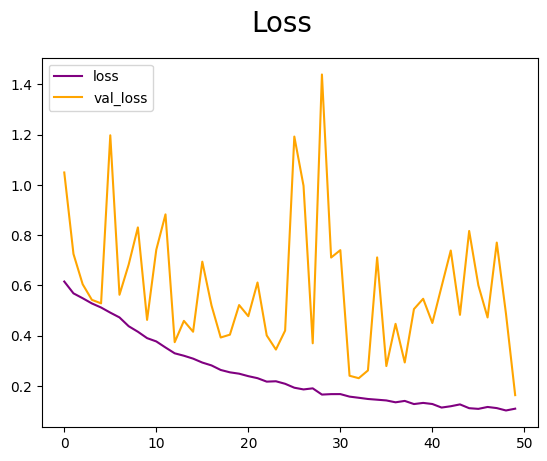

In [41]:
fig = plt.figure()
plt.plot(history.history['loss'], color='purple', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

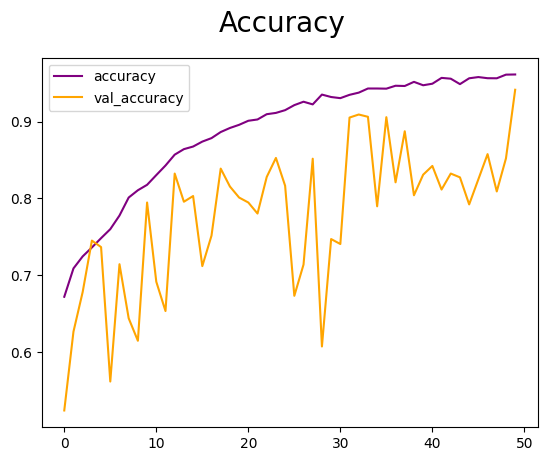

In [42]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='purple', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [43]:
_, accu = student_scratch.evaluate(test)
print('Final Test Accuracy = {:.3f}%'.format(accu * 100))

63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.9347 - loss: 0.1697
Final Test Accuracy = 93.750%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━

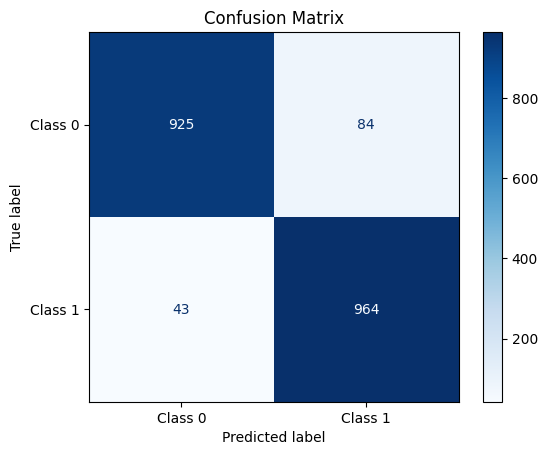

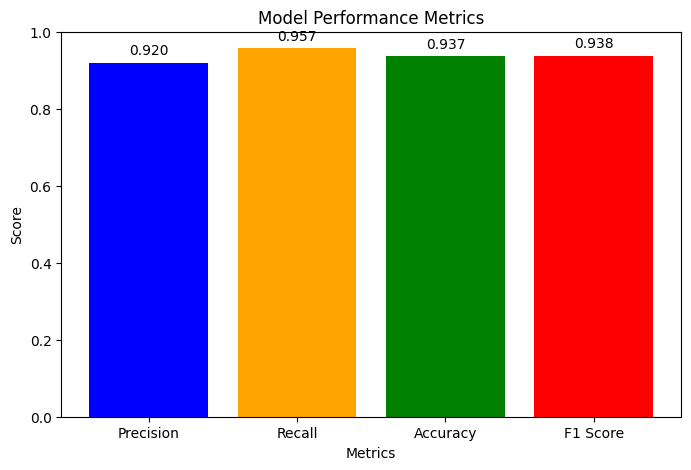

In [44]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Step 1: Predict labels for the test set
true_labels = []
pred_labels = []

for batch in test:  # Assuming `test` is your test dataset
    images, labels = batch
    predictions = student_scratch.predict(images)  # Replace with your model name if different
    true_labels.extend(labels.numpy())
    pred_labels.extend((predictions > 0.5).astype("int32").flatten())

# Step 2: Calculate precision, recall, accuracy, and F1 score
precision = precision_score(true_labels, pred_labels)
recall = recall_score(true_labels, pred_labels)
accuracy = accuracy_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels)

# Step 3: Create a DataFrame to display the metrics
metrics = {
    "Metric": ["Precision", "Recall", "Accuracy", "F1 Score"],
    "Score": [precision, recall, accuracy, f1]
}
metrics_df = pd.DataFrame(metrics)



# Step 5: Compute the confusion matrix and plot it
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Step 4: Plotting the metrics as a bar chart
plt.figure(figsize=(8, 5))
plt.bar(metrics_df['Metric'], metrics_df['Score'], color=['blue', 'orange', 'green', 'red'])
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
plt.title('Model Performance Metrics')
plt.xlabel('Metrics')
plt.ylabel('Score')
for i in range(len(metrics_df)):
    plt.text(i, metrics_df['Score'][i] + 0.02, f"{metrics_df['Score'][i]:.3f}", ha='center')

plt.show()

# **Distiller Class**

In [45]:
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.
        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results


# **Student Model**

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization, GlobalAveragePooling2D, Dense, Input

# Instantiate the Sequential model
student = Sequential()

# Adding the Input layer with the specified shape
student.add(Input(shape=(224, 224, 3)))  # Specify the input shape here

# Adding the convolutional layers
student.add(Conv2D(32, (3, 3), activation='relu'))  
student.add(BatchNormalization())  
student.add(MaxPooling2D(pool_size=(2, 2)))  
student.add(Dropout(0.3))  

student.add(Conv2D(64, (3, 3), activation='relu'))  
student.add(BatchNormalization())  
student.add(MaxPooling2D(pool_size=(2, 2)))  
student.add(Dropout(0.4))  

student.add(Conv2D(128, (3, 3), activation='relu'))  
student.add(BatchNormalization())  
student.add(MaxPooling2D(pool_size=(2, 2)))  
student.add(Dropout(0.4))  

student.add(Conv2D(256, (3, 3), activation='relu'))  
student.add(BatchNormalization())  
student.add(MaxPooling2D(pool_size=(2, 2)))  
student.add(Dropout(0.5))  

# Global Average Pooling instead of Flatten
student.add(GlobalAveragePooling2D())  

# Fully connected layers
student.add(Dense(512, activation='relu'))  
student.add(Dropout(0.5))  

# Output layer
student.add(Dense(1))  
#, activation='sigmoid'

In [47]:
logdir = 'logs3'  # Directory where TensorBoard logs will be saved
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)  # Callback to log training process for TensorBoard

# **Train the Student Model with Distillation for various alpha and temperature value**

In [48]:
# Define a list of temperature values to test
temperature_values = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
results = {}

for temp in temperature_values:
    print(f"\nTraining with temperature = {temp}")
    
    # Initialize and compile distiller with the current temperature
    distiller = Distiller(student=student, teacher=teacher)
    distiller.compile(
        optimizer=keras.optimizers.Adam(),
        metrics=[keras.metrics.BinaryAccuracy()],
        student_loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
        distillation_loss_fn=keras.losses.KLDivergence(),
        alpha=0.1,
        temperature=temp,
    )

    # Train the model
    history = distiller.fit(
        train,
        epochs=50,
        validation_data=val,
        verbose=1
    )

    # Evaluate on the test dataset and store results
    evaluation = distiller.evaluate(test)
    results[temp] = evaluation

# Print results for all temperature values
print("\nEvaluation Results for Different Temperatures:")
for temp, result in results.items():
    print(f"Temperature {temp}: {result}")



Training with temperature = 1
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py:578: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


  1/296 ━━━━━━━━━━━━━━━━━━━━ 1:56:47 24s/step - binary_accuracy: 0.4062 - distillation_loss: 0.0000e+00 - loss: 0.1155 - student_loss: 0.8984

I0000 00:00:1731162183.921921     134 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill loads



296/296 ━━━━━━━━━━━━━━━━━━━━ 58s 116ms/step - binary_accuracy: 0.6450 - distillation_loss: 0.0000e+00 - loss: -0.0174 - student_loss: 0.6171 - val_binary_accuracy: 0.5253 - val_loss: -0.4523 - val_student_loss: 0.6713
Epoch 2/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 33s 113ms/step - binary_accuracy: 0.6913 - distillation_loss: 0.0000e+00 - loss: 0.0227 - student_loss: 0.5654 - val_binary_accuracy: 0.6845 - val_loss: 0.5153 - val_student_loss: 0.7721
Epoch 3/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 34s 113ms/step - binary_accuracy: 0.7154 - distillation_loss: 0.0000e+00 - loss: 0.0567 - student_loss: 0.5466 - val_binary_accuracy: 0.4886 - val_loss: -2.4278 - val_student_loss: 1.1224
Epoch 4/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 34s 114ms/step - binary_accuracy: 0.7284 - distillation_loss: 0.0000e+00 - loss: 0.0703 - student_loss: 0.5343 - val_binary_accuracy: 0.6939 - val_loss: 0.0315 - val_student_loss: 0.5614
Epoch 5/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 34s 115ms/step - binary_accuracy: 0.7350 - distillation_loss

I0000 00:00:1731163929.207869     134 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill loads



296/296 ━━━━━━━━━━━━━━━━━━━━ 60s 117ms/step - binary_accuracy: 0.9568 - distillation_loss: 0.0000e+00 - loss: 0.9775 - student_loss: 0.1127 - val_binary_accuracy: 0.8829 - val_loss: 3.6120 - val_student_loss: 0.3679
Epoch 2/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 34s 116ms/step - binary_accuracy: 0.9599 - distillation_loss: 0.0000e+00 - loss: 1.1988 - student_loss: 0.1108 - val_binary_accuracy: 0.8775 - val_loss: 4.6736 - val_student_loss: 0.2961
Epoch 3/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 34s 115ms/step - binary_accuracy: 0.9603 - distillation_loss: 0.0000e+00 - loss: 1.2150 - student_loss: 0.1079 - val_binary_accuracy: 0.8983 - val_loss: 2.4566 - val_student_loss: 0.0656
Epoch 4/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 34s 115ms/step - binary_accuracy: 0.9627 - distillation_loss: 0.0000e+00 - loss: 1.2629 - student_loss: 0.0996 - val_binary_accuracy: 0.9067 - val_loss: 3.0120 - val_student_loss: 0.0775
Epoch 5/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 34s 114ms/step - binary_accuracy: 0.9641 - distillation_loss: 0

I0000 00:00:1731165643.062506     135 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill loads



296/296 ━━━━━━━━━━━━━━━━━━━━ 57s 112ms/step - binary_accuracy: 0.9789 - distillation_loss: 0.0000e+00 - loss: 2.0121 - student_loss: 0.0614 - val_binary_accuracy: 0.9246 - val_loss: 6.8137 - val_student_loss: 0.1766
Epoch 2/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 33s 111ms/step - binary_accuracy: 0.9745 - distillation_loss: 0.0000e+00 - loss: 1.9225 - student_loss: 0.0576 - val_binary_accuracy: 0.9415 - val_loss: 3.3058 - val_student_loss: 0.1338
Epoch 3/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 33s 110ms/step - binary_accuracy: 0.9819 - distillation_loss: 0.0000e+00 - loss: 2.2319 - student_loss: 0.0588 - val_binary_accuracy: 0.9132 - val_loss: 0.1462 - val_student_loss: 0.6442
Epoch 4/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 33s 111ms/step - binary_accuracy: 0.9763 - distillation_loss: 0.0000e+00 - loss: 1.6201 - student_loss: 0.0572 - val_binary_accuracy: 0.8839 - val_loss: 10.5294 - val_student_loss: 0.9326
Epoch 5/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 33s 111ms/step - binary_accuracy: 0.9820 - distillation_loss: 

I0000 00:00:1731167322.526480     136 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill loads



296/296 ━━━━━━━━━━━━━━━━━━━━ 55s 110ms/step - binary_accuracy: 0.9853 - distillation_loss: 0.0000e+00 - loss: 2.5620 - student_loss: 0.0404 - val_binary_accuracy: 0.9410 - val_loss: 7.2401 - val_student_loss: 0.2185
Epoch 2/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 109ms/step - binary_accuracy: 0.9821 - distillation_loss: 0.0000e+00 - loss: 3.2528 - student_loss: 0.0548 - val_binary_accuracy: 0.8909 - val_loss: 14.1470 - val_student_loss: 0.2658
Epoch 3/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 110ms/step - binary_accuracy: 0.9832 - distillation_loss: 0.0000e+00 - loss: 2.9506 - student_loss: 0.0489 - val_binary_accuracy: 0.9583 - val_loss: 5.6134 - val_student_loss: 0.0715
Epoch 4/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 33s 110ms/step - binary_accuracy: 0.9864 - distillation_loss: 0.0000e+00 - loss: 2.4368 - student_loss: 0.0448 - val_binary_accuracy: 0.9509 - val_loss: 5.3101 - val_student_loss: 0.3456
Epoch 5/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 33s 111ms/step - binary_accuracy: 0.9874 - distillation_loss: 

I0000 00:00:1731168992.481131     133 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill loads



296/296 ━━━━━━━━━━━━━━━━━━━━ 56s 113ms/step - binary_accuracy: 0.9897 - distillation_loss: 0.0000e+00 - loss: 3.1695 - student_loss: 0.0382 - val_binary_accuracy: 0.9430 - val_loss: 8.7582 - val_student_loss: 0.4727
Epoch 2/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 33s 111ms/step - binary_accuracy: 0.9900 - distillation_loss: 0.0000e+00 - loss: 3.0005 - student_loss: 0.0349 - val_binary_accuracy: 0.9067 - val_loss: 13.8475 - val_student_loss: 0.3034
Epoch 3/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 110ms/step - binary_accuracy: 0.9867 - distillation_loss: 0.0000e+00 - loss: 2.7221 - student_loss: 0.0431 - val_binary_accuracy: 0.7599 - val_loss: 28.7174 - val_student_loss: 2.0678
Epoch 4/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 33s 111ms/step - binary_accuracy: 0.9901 - distillation_loss: 0.0000e+00 - loss: 3.4391 - student_loss: 0.0280 - val_binary_accuracy: 0.9504 - val_loss: 5.4644 - val_student_loss: 0.2704
Epoch 5/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 109ms/step - binary_accuracy: 0.9877 - distillation_loss:

I0000 00:00:1731170696.998221     133 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill loads



296/296 ━━━━━━━━━━━━━━━━━━━━ 58s 112ms/step - binary_accuracy: 0.9886 - distillation_loss: 0.0000e+00 - loss: 3.0114 - student_loss: 0.0347 - val_binary_accuracy: 0.9420 - val_loss: 9.4056 - val_student_loss: 0.5797
Epoch 2/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 110ms/step - binary_accuracy: 0.9890 - distillation_loss: 0.0000e+00 - loss: 3.4296 - student_loss: 0.0320 - val_binary_accuracy: 0.9261 - val_loss: 4.5949 - val_student_loss: 0.1430
Epoch 3/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 41s 139ms/step - binary_accuracy: 0.9881 - distillation_loss: 0.0000e+00 - loss: 3.3384 - student_loss: 0.0417 - val_binary_accuracy: 0.9067 - val_loss: 6.6725 - val_student_loss: 0.3157
Epoch 4/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 38s 127ms/step - binary_accuracy: 0.9902 - distillation_loss: 0.0000e+00 - loss: 3.4306 - student_loss: 0.0309 - val_binary_accuracy: 0.9658 - val_loss: 3.5125 - val_student_loss: 0.0272
Epoch 5/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 33s 112ms/step - binary_accuracy: 0.9902 - distillation_loss: 0

I0000 00:00:1731172392.188560     136 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill loads



296/296 ━━━━━━━━━━━━━━━━━━━━ 56s 112ms/step - binary_accuracy: 0.9897 - distillation_loss: 0.0000e+00 - loss: 4.1000 - student_loss: 0.0376 - val_binary_accuracy: 0.9236 - val_loss: 3.2518 - val_student_loss: 0.7218
Epoch 2/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 33s 112ms/step - binary_accuracy: 0.9895 - distillation_loss: 0.0000e+00 - loss: 3.3469 - student_loss: 0.0299 - val_binary_accuracy: 0.9663 - val_loss: 3.5658 - val_student_loss: 0.0892
Epoch 3/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 34s 114ms/step - binary_accuracy: 0.9924 - distillation_loss: 0.0000e+00 - loss: 3.2531 - student_loss: 0.0260 - val_binary_accuracy: 0.9196 - val_loss: 4.2947 - val_student_loss: 0.9069
Epoch 4/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 34s 113ms/step - binary_accuracy: 0.9892 - distillation_loss: 0.0000e+00 - loss: 3.8256 - student_loss: 0.0292 - val_binary_accuracy: 0.9618 - val_loss: 5.6030 - val_student_loss: 0.4197
Epoch 5/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 33s 112ms/step - binary_accuracy: 0.9914 - distillation_loss: 0

I0000 00:00:1731174083.925107     133 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill loads



296/296 ━━━━━━━━━━━━━━━━━━━━ 56s 112ms/step - binary_accuracy: 0.9920 - distillation_loss: 0.0000e+00 - loss: 4.0399 - student_loss: 0.0252 - val_binary_accuracy: 0.9420 - val_loss: 6.6133 - val_student_loss: 0.7490
Epoch 2/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 33s 110ms/step - binary_accuracy: 0.9948 - distillation_loss: 0.0000e+00 - loss: 3.9379 - student_loss: 0.0319 - val_binary_accuracy: 0.9583 - val_loss: 3.5151 - val_student_loss: 0.1732
Epoch 3/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 33s 110ms/step - binary_accuracy: 0.9924 - distillation_loss: 0.0000e+00 - loss: 3.0690 - student_loss: 0.0264 - val_binary_accuracy: 0.9325 - val_loss: 9.3232 - val_student_loss: 0.6302
Epoch 4/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 33s 111ms/step - binary_accuracy: 0.9914 - distillation_loss: 0.0000e+00 - loss: 4.2744 - student_loss: 0.0250 - val_binary_accuracy: 0.8869 - val_loss: -2.3750 - val_student_loss: 0.5206
Epoch 5/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 33s 111ms/step - binary_accuracy: 0.9950 - distillation_loss: 

I0000 00:00:1731175786.003004     133 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill loads



296/296 ━━━━━━━━━━━━━━━━━━━━ 56s 113ms/step - binary_accuracy: 0.9911 - distillation_loss: 0.0000e+00 - loss: 4.5086 - student_loss: 0.0300 - val_binary_accuracy: 0.9638 - val_loss: 8.7639 - val_student_loss: 0.1276
Epoch 2/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 34s 113ms/step - binary_accuracy: 0.9935 - distillation_loss: 0.0000e+00 - loss: 4.3548 - student_loss: 0.0214 - val_binary_accuracy: 0.9365 - val_loss: 6.1920 - val_student_loss: 0.0425
Epoch 3/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 35s 118ms/step - binary_accuracy: 0.9915 - distillation_loss: 0.0000e+00 - loss: 3.3127 - student_loss: 0.0210 - val_binary_accuracy: 0.9058 - val_loss: 14.0553 - val_student_loss: 0.6737
Epoch 4/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 34s 114ms/step - binary_accuracy: 0.9925 - distillation_loss: 0.0000e+00 - loss: 3.7012 - student_loss: 0.0304 - val_binary_accuracy: 0.9484 - val_loss: 5.5580 - val_student_loss: 0.0799
Epoch 5/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 33s 113ms/step - binary_accuracy: 0.9929 - distillation_loss: 

I0000 00:00:1731177496.515446     135 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill loads



296/296 ━━━━━━━━━━━━━━━━━━━━ 56s 112ms/step - binary_accuracy: 0.9941 - distillation_loss: 0.0000e+00 - loss: 3.8661 - student_loss: 0.0233 - val_binary_accuracy: 0.9489 - val_loss: 11.1120 - val_student_loss: 0.0442
Epoch 2/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 33s 110ms/step - binary_accuracy: 0.9917 - distillation_loss: 0.0000e+00 - loss: 4.3986 - student_loss: 0.0267 - val_binary_accuracy: 0.9067 - val_loss: -1.7856 - val_student_loss: 0.5077
Epoch 3/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 33s 111ms/step - binary_accuracy: 0.9921 - distillation_loss: 0.0000e+00 - loss: 3.9519 - student_loss: 0.0225 - val_binary_accuracy: 0.9628 - val_loss: 8.9268 - val_student_loss: 0.6821
Epoch 4/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 33s 111ms/step - binary_accuracy: 0.9921 - distillation_loss: 0.0000e+00 - loss: 3.7405 - student_loss: 0.0270 - val_binary_accuracy: 0.9573 - val_loss: 5.0671 - val_student_loss: 0.3044
Epoch 5/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 33s 112ms/step - binary_accuracy: 0.9930 - distillation_loss:

I0000 00:00:1731179183.152907     133 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill loads



296/296 ━━━━━━━━━━━━━━━━━━━━ 58s 112ms/step - binary_accuracy: 0.9927 - distillation_loss: 0.0000e+00 - loss: 4.0335 - student_loss: 0.0254 - val_binary_accuracy: 0.9430 - val_loss: 5.0100 - val_student_loss: 0.0794
Epoch 2/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 33s 112ms/step - binary_accuracy: 0.9921 - distillation_loss: 0.0000e+00 - loss: 4.3125 - student_loss: 0.0225 - val_binary_accuracy: 0.9360 - val_loss: 8.0447 - val_student_loss: 0.2093
Epoch 3/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 33s 112ms/step - binary_accuracy: 0.9925 - distillation_loss: 0.0000e+00 - loss: 4.0369 - student_loss: 0.0225 - val_binary_accuracy: 0.9306 - val_loss: 2.0206 - val_student_loss: 0.2927
Epoch 4/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 34s 113ms/step - binary_accuracy: 0.9931 - distillation_loss: 0.0000e+00 - loss: 4.1239 - student_loss: 0.0254 - val_binary_accuracy: 0.9737 - val_loss: 5.2803 - val_student_loss: 0.5356
Epoch 5/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 33s 110ms/step - binary_accuracy: 0.9897 - distillation_loss: 0

In [49]:
# Define a list of temperature values to test
temperature_values = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
results = {}

for temp in temperature_values:
    print(f"\nTraining with temperature = {temp}")
    
    # Initialize and compile distiller with the current temperature
    distiller = Distiller(student=student, teacher=teacher)
    distiller.compile(
        optimizer=keras.optimizers.Adam(),
        metrics=[keras.metrics.BinaryAccuracy()],
        student_loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
        distillation_loss_fn=keras.losses.KLDivergence(),
        alpha=0.2,
        temperature=temp,
    )

    # Train the model
    history = distiller.fit(
        train,
        epochs=20,
        validation_data=val,
        verbose=1
    )

    # Evaluate on the test dataset and store results
    evaluation = distiller.evaluate(test)
    results[temp] = evaluation

# Print results for all temperature values
print("\nEvaluation Results for Different Temperatures:")
for temp, result in results.items():
    print(f"Temperature {temp}: {result}")



Training with temperature = 1
Epoch 1/50
  1/296 ━━━━━━━━━━━━━━━━━━━━ 1:51:22 23s/step - binary_accuracy: 0.9688 - distillation_loss: 0.0000e+00 - loss: 6.4700 - student_loss: 0.2425

I0000 00:00:1731180880.967237     135 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill loads



296/296 ━━━━━━━━━━━━━━━━━━━━ 55s 110ms/step - binary_accuracy: 0.9939 - distillation_loss: 0.0000e+00 - loss: 3.7218 - student_loss: 0.0237 - val_binary_accuracy: 0.9633 - val_loss: 9.8503 - val_student_loss: 0.3386
Epoch 2/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 33s 110ms/step - binary_accuracy: 0.9932 - distillation_loss: 0.0000e+00 - loss: 4.3868 - student_loss: 0.0292 - val_binary_accuracy: 0.9643 - val_loss: 5.4453 - val_student_loss: 0.1010
Epoch 3/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 33s 111ms/step - binary_accuracy: 0.9925 - distillation_loss: 0.0000e+00 - loss: 4.4539 - student_loss: 0.0285 - val_binary_accuracy: 0.9479 - val_loss: 3.8217 - val_student_loss: 0.9823
Epoch 4/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 33s 110ms/step - binary_accuracy: 0.9926 - distillation_loss: 0.0000e+00 - loss: 4.5155 - student_loss: 0.0254 - val_binary_accuracy: 0.9628 - val_loss: 9.6125 - val_student_loss: 0.2966
Epoch 5/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 109ms/step - binary_accuracy: 0.9952 - distillation_loss: 0

I0000 00:00:1731182563.713381     134 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill loads



296/296 ━━━━━━━━━━━━━━━━━━━━ 55s 110ms/step - binary_accuracy: 0.9937 - distillation_loss: 0.0000e+00 - loss: 4.7420 - student_loss: 0.0252 - val_binary_accuracy: 0.9633 - val_loss: 9.4061 - val_student_loss: 0.4390
Epoch 2/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 109ms/step - binary_accuracy: 0.9947 - distillation_loss: 0.0000e+00 - loss: 4.7773 - student_loss: 0.0197 - val_binary_accuracy: 0.9549 - val_loss: 3.8508 - val_student_loss: 0.2795
Epoch 3/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 33s 110ms/step - binary_accuracy: 0.9941 - distillation_loss: 0.0000e+00 - loss: 5.2252 - student_loss: 0.0227 - val_binary_accuracy: 0.9444 - val_loss: 1.2809 - val_student_loss: 0.0577
Epoch 4/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 109ms/step - binary_accuracy: 0.9940 - distillation_loss: 0.0000e+00 - loss: 4.7967 - student_loss: 0.0172 - val_binary_accuracy: 0.9633 - val_loss: 2.9418 - val_student_loss: 0.1238
Epoch 5/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 33s 110ms/step - binary_accuracy: 0.9925 - distillation_loss: 0

I0000 00:00:1731184234.301762     136 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill loads



296/296 ━━━━━━━━━━━━━━━━━━━━ 55s 110ms/step - binary_accuracy: 0.9942 - distillation_loss: 0.0000e+00 - loss: 5.3340 - student_loss: 0.0188 - val_binary_accuracy: 0.9643 - val_loss: 10.2683 - val_student_loss: 0.0878
Epoch 2/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 33s 112ms/step - binary_accuracy: 0.9928 - distillation_loss: 0.0000e+00 - loss: 5.3773 - student_loss: 0.0182 - val_binary_accuracy: 0.9673 - val_loss: 6.0768 - val_student_loss: 0.0362
Epoch 3/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 108ms/step - binary_accuracy: 0.9940 - distillation_loss: 0.0000e+00 - loss: 6.2141 - student_loss: 0.0228 - val_binary_accuracy: 0.8864 - val_loss: 27.3494 - val_student_loss: 3.1305
Epoch 4/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 109ms/step - binary_accuracy: 0.9941 - distillation_loss: 0.0000e+00 - loss: 6.4735 - student_loss: 0.0191 - val_binary_accuracy: 0.9563 - val_loss: 8.9707 - val_student_loss: 3.0429
Epoch 5/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 108ms/step - binary_accuracy: 0.9947 - distillation_loss:

I0000 00:00:1731185892.144768     134 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill loads



296/296 ━━━━━━━━━━━━━━━━━━━━ 55s 111ms/step - binary_accuracy: 0.9949 - distillation_loss: 0.0000e+00 - loss: 4.8932 - student_loss: 0.0123 - val_binary_accuracy: 0.9643 - val_loss: 3.7256 - val_student_loss: 0.1423
Epoch 2/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 110ms/step - binary_accuracy: 0.9936 - distillation_loss: 0.0000e+00 - loss: 5.6831 - student_loss: 0.0274 - val_binary_accuracy: 0.9201 - val_loss: 17.1580 - val_student_loss: 0.9199
Epoch 3/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 33s 110ms/step - binary_accuracy: 0.9920 - distillation_loss: 0.0000e+00 - loss: 4.5320 - student_loss: 0.0274 - val_binary_accuracy: 0.9286 - val_loss: 6.5484 - val_student_loss: 0.2491
Epoch 4/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 110ms/step - binary_accuracy: 0.9940 - distillation_loss: 0.0000e+00 - loss: 5.3046 - student_loss: 0.0182 - val_binary_accuracy: 0.9559 - val_loss: 6.6696 - val_student_loss: 0.7258
Epoch 5/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 109ms/step - binary_accuracy: 0.9935 - distillation_loss: 

KeyboardInterrupt: 

In [50]:
# Define a list of temperature values to test
temperature_values = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
results = {}

for temp in temperature_values:
    print(f"\nTraining with temperature = {temp}")
    
    # Initialize and compile distiller with the current temperature
    distiller = Distiller(student=student, teacher=teacher)
    distiller.compile(
        optimizer=keras.optimizers.Adam(),
        metrics=[keras.metrics.BinaryAccuracy()],
        student_loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
        distillation_loss_fn=keras.losses.KLDivergence(),
        alpha=0.5,
        temperature=temp,
    )

    # Train the model
    history = distiller.fit(
        train,
        epochs=30,
        validation_data=val,
        verbose=1
    )

    # Evaluate on the test dataset and store results
    evaluation = distiller.evaluate(test)
    results[temp] = evaluation

# Print results for all temperature values
print("\nEvaluation Results for Different Temperatures:")
for temp, result in results.items():
    print(f"Temperature {temp}: {result}")



Training with temperature = 1
Epoch 1/30
  1/296 ━━━━━━━━━━━━━━━━━━━━ 2:02:41 25s/step - binary_accuracy: 1.0000 - distillation_loss: 0.0000e+00 - loss: 11.8674 - student_loss: 0.0013

I0000 00:00:1731186803.683552     134 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill loads



296/296 ━━━━━━━━━━━━━━━━━━━━ 58s 111ms/step - binary_accuracy: 0.9971 - distillation_loss: 0.0000e+00 - loss: 4.4868 - student_loss: 0.0175 - val_binary_accuracy: 0.9603 - val_loss: 4.7381 - val_student_loss: 0.4859
Epoch 2/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 110ms/step - binary_accuracy: 0.9943 - distillation_loss: 0.0000e+00 - loss: 5.1410 - student_loss: 0.0206 - val_binary_accuracy: 0.9534 - val_loss: 12.2850 - val_student_loss: 1.2121
Epoch 3/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 109ms/step - binary_accuracy: 0.9951 - distillation_loss: 0.0000e+00 - loss: 6.1745 - student_loss: 0.0226 - val_binary_accuracy: 0.9534 - val_loss: 6.1619 - val_student_loss: 0.5803
Epoch 4/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 33s 110ms/step - binary_accuracy: 0.9934 - distillation_loss: 0.0000e+00 - loss: 5.8258 - student_loss: 0.0234 - val_binary_accuracy: 0.9588 - val_loss: 2.4634 - val_student_loss: 1.1922
Epoch 5/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 33s 111ms/step - binary_accuracy: 0.9925 - distillation_loss: 

I0000 00:00:1731187811.668495     133 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill loads



296/296 ━━━━━━━━━━━━━━━━━━━━ 55s 110ms/step - binary_accuracy: 0.9944 - distillation_loss: 0.0000e+00 - loss: 5.4465 - student_loss: 0.0179 - val_binary_accuracy: 0.9618 - val_loss: 12.7112 - val_student_loss: 0.2253
Epoch 2/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 109ms/step - binary_accuracy: 0.9955 - distillation_loss: 0.0000e+00 - loss: 4.9161 - student_loss: 0.0141 - val_binary_accuracy: 0.9216 - val_loss: 17.7098 - val_student_loss: 1.9041
Epoch 3/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 109ms/step - binary_accuracy: 0.9919 - distillation_loss: 0.0000e+00 - loss: 6.7539 - student_loss: 0.0273 - val_binary_accuracy: 0.9593 - val_loss: 12.4664 - val_student_loss: 0.0333
Epoch 4/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 109ms/step - binary_accuracy: 0.9948 - distillation_loss: 0.0000e+00 - loss: 4.8393 - student_loss: 0.0221 - val_binary_accuracy: 0.9618 - val_loss: 9.2506 - val_student_loss: 0.3876
Epoch 5/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 109ms/step - binary_accuracy: 0.9934 - distillation_loss

I0000 00:00:1731188813.999118     133 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill loads



296/296 ━━━━━━━━━━━━━━━━━━━━ 55s 110ms/step - binary_accuracy: 0.9948 - distillation_loss: 0.0000e+00 - loss: 4.0873 - student_loss: 0.0175 - val_binary_accuracy: 0.9385 - val_loss: 11.8762 - val_student_loss: 0.7402
Epoch 2/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 109ms/step - binary_accuracy: 0.9946 - distillation_loss: 0.0000e+00 - loss: 5.3974 - student_loss: 0.0183 - val_binary_accuracy: 0.9717 - val_loss: 9.2538 - val_student_loss: 0.2592
Epoch 3/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 33s 111ms/step - binary_accuracy: 0.9936 - distillation_loss: 0.0000e+00 - loss: 5.8640 - student_loss: 0.0191 - val_binary_accuracy: 0.9355 - val_loss: 1.9995 - val_student_loss: 0.0725
Epoch 4/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 33s 110ms/step - binary_accuracy: 0.9945 - distillation_loss: 0.0000e+00 - loss: 4.9917 - student_loss: 0.0194 - val_binary_accuracy: 0.9360 - val_loss: 13.4580 - val_student_loss: 0.3805
Epoch 5/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 33s 110ms/step - binary_accuracy: 0.9904 - distillation_loss:

I0000 00:00:1731189819.457141     133 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill loads



296/296 ━━━━━━━━━━━━━━━━━━━━ 55s 110ms/step - binary_accuracy: 0.9956 - distillation_loss: 0.0000e+00 - loss: 4.5818 - student_loss: 0.0221 - val_binary_accuracy: 0.9479 - val_loss: 4.2400 - val_student_loss: 0.4145
Epoch 2/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 110ms/step - binary_accuracy: 0.9935 - distillation_loss: 0.0000e+00 - loss: 4.3425 - student_loss: 0.0235 - val_binary_accuracy: 0.9722 - val_loss: 6.3599 - val_student_loss: 0.1891
Epoch 3/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 109ms/step - binary_accuracy: 0.9962 - distillation_loss: 0.0000e+00 - loss: 5.2931 - student_loss: 0.0153 - val_binary_accuracy: 0.9623 - val_loss: 9.9953 - val_student_loss: 0.1675
Epoch 4/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 109ms/step - binary_accuracy: 0.9952 - distillation_loss: 0.0000e+00 - loss: 6.9156 - student_loss: 0.0169 - val_binary_accuracy: 0.9678 - val_loss: 8.3217 - val_student_loss: 0.5009
Epoch 5/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 109ms/step - binary_accuracy: 0.9940 - distillation_loss: 0

I0000 00:00:1731190833.695849     133 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill loads



296/296 ━━━━━━━━━━━━━━━━━━━━ 55s 109ms/step - binary_accuracy: 0.9964 - distillation_loss: 0.0000e+00 - loss: 4.8960 - student_loss: 0.0225 - val_binary_accuracy: 0.9494 - val_loss: 9.9556 - val_student_loss: 1.0436
Epoch 2/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 110ms/step - binary_accuracy: 0.9956 - distillation_loss: 0.0000e+00 - loss: 4.2367 - student_loss: 0.0176 - val_binary_accuracy: 0.9593 - val_loss: 10.1518 - val_student_loss: 1.3332
Epoch 3/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 33s 111ms/step - binary_accuracy: 0.9932 - distillation_loss: 0.0000e+00 - loss: 4.1132 - student_loss: 0.0207 - val_binary_accuracy: 0.9658 - val_loss: 5.8604 - val_student_loss: 0.0042
Epoch 4/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 33s 110ms/step - binary_accuracy: 0.9956 - distillation_loss: 0.0000e+00 - loss: 4.8121 - student_loss: 0.0219 - val_binary_accuracy: 0.9444 - val_loss: 2.4369 - val_student_loss: 0.2944
Epoch 5/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 108ms/step - binary_accuracy: 0.9945 - distillation_loss: 

I0000 00:00:1731191836.612353     133 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill loads



296/296 ━━━━━━━━━━━━━━━━━━━━ 55s 110ms/step - binary_accuracy: 0.9943 - distillation_loss: 0.0000e+00 - loss: 6.1595 - student_loss: 0.0178 - val_binary_accuracy: 0.9658 - val_loss: 7.6306 - val_student_loss: 0.6296
Epoch 2/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 109ms/step - binary_accuracy: 0.9945 - distillation_loss: 0.0000e+00 - loss: 6.3729 - student_loss: 0.0222 - val_binary_accuracy: 0.9603 - val_loss: 10.7773 - val_student_loss: 1.1700
Epoch 3/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 109ms/step - binary_accuracy: 0.9949 - distillation_loss: 0.0000e+00 - loss: 6.6534 - student_loss: 0.0134 - val_binary_accuracy: 0.9663 - val_loss: 9.8905 - val_student_loss: 0.2029
Epoch 4/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 109ms/step - binary_accuracy: 0.9929 - distillation_loss: 0.0000e+00 - loss: 5.1287 - student_loss: 0.0265 - val_binary_accuracy: 0.9618 - val_loss: 8.2353 - val_student_loss: 0.0607
Epoch 5/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 109ms/step - binary_accuracy: 0.9925 - distillation_loss: 

I0000 00:00:1731192844.530062     133 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill loads



296/296 ━━━━━━━━━━━━━━━━━━━━ 55s 111ms/step - binary_accuracy: 0.9960 - distillation_loss: 0.0000e+00 - loss: 4.9741 - student_loss: 0.0166 - val_binary_accuracy: 0.9563 - val_loss: 5.8231 - val_student_loss: 0.8191
Epoch 2/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 108ms/step - binary_accuracy: 0.9928 - distillation_loss: 0.0000e+00 - loss: 5.3440 - student_loss: 0.0234 - val_binary_accuracy: 0.9697 - val_loss: 6.9755 - val_student_loss: 0.7564
Epoch 3/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 33s 111ms/step - binary_accuracy: 0.9946 - distillation_loss: 0.0000e+00 - loss: 4.5931 - student_loss: 0.0189 - val_binary_accuracy: 0.9211 - val_loss: -0.7026 - val_student_loss: 0.4356
Epoch 4/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 109ms/step - binary_accuracy: 0.9946 - distillation_loss: 0.0000e+00 - loss: 4.8635 - student_loss: 0.0153 - val_binary_accuracy: 0.9673 - val_loss: 9.1199 - val_student_loss: 0.1218
Epoch 5/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 108ms/step - binary_accuracy: 0.9959 - distillation_loss: 

I0000 00:00:1731193875.374735     135 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill loads



296/296 ━━━━━━━━━━━━━━━━━━━━ 60s 113ms/step - binary_accuracy: 0.9954 - distillation_loss: 0.0000e+00 - loss: 5.7917 - student_loss: 0.0178 - val_binary_accuracy: 0.9608 - val_loss: 7.0989 - val_student_loss: 0.1595
Epoch 2/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 109ms/step - binary_accuracy: 0.9950 - distillation_loss: 0.0000e+00 - loss: 5.5802 - student_loss: 0.0209 - val_binary_accuracy: 0.9509 - val_loss: 15.3110 - val_student_loss: 0.4663
Epoch 3/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 33s 111ms/step - binary_accuracy: 0.9930 - distillation_loss: 0.0000e+00 - loss: 5.3835 - student_loss: 0.0215 - val_binary_accuracy: 0.9752 - val_loss: 5.4004 - val_student_loss: 0.1906
Epoch 4/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 33s 113ms/step - binary_accuracy: 0.9947 - distillation_loss: 0.0000e+00 - loss: 5.3213 - student_loss: 0.0191 - val_binary_accuracy: 0.8219 - val_loss: -6.3667 - val_student_loss: 1.2019
Epoch 5/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 33s 112ms/step - binary_accuracy: 0.9938 - distillation_loss:

I0000 00:00:1731194899.229071     134 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill loads



296/296 ━━━━━━━━━━━━━━━━━━━━ 55s 111ms/step - binary_accuracy: 0.9944 - distillation_loss: 0.0000e+00 - loss: 6.0132 - student_loss: 0.0242 - val_binary_accuracy: 0.9509 - val_loss: 15.2446 - val_student_loss: 1.7227
Epoch 2/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 109ms/step - binary_accuracy: 0.9958 - distillation_loss: 0.0000e+00 - loss: 5.1901 - student_loss: 0.0129 - val_binary_accuracy: 0.9648 - val_loss: 3.7217 - val_student_loss: 0.9042
Epoch 3/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 109ms/step - binary_accuracy: 0.9963 - distillation_loss: 0.0000e+00 - loss: 5.6423 - student_loss: 0.0147 - val_binary_accuracy: 0.9236 - val_loss: 0.3850 - val_student_loss: 0.5903
Epoch 4/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 109ms/step - binary_accuracy: 0.9940 - distillation_loss: 0.0000e+00 - loss: 4.4925 - student_loss: 0.0193 - val_binary_accuracy: 0.9544 - val_loss: 12.2925 - val_student_loss: 0.7350
Epoch 5/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 108ms/step - binary_accuracy: 0.9954 - distillation_loss:

I0000 00:00:1731195898.589951     133 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill loads



296/296 ━━━━━━━━━━━━━━━━━━━━ 55s 111ms/step - binary_accuracy: 0.9957 - distillation_loss: 0.0000e+00 - loss: 7.8799 - student_loss: 0.0184 - val_binary_accuracy: 0.9464 - val_loss: 1.7423 - val_student_loss: 0.2352
Epoch 2/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 109ms/step - binary_accuracy: 0.9944 - distillation_loss: 0.0000e+00 - loss: 7.0344 - student_loss: 0.0220 - val_binary_accuracy: 0.9697 - val_loss: 11.6119 - val_student_loss: 0.0153
Epoch 3/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 110ms/step - binary_accuracy: 0.9958 - distillation_loss: 0.0000e+00 - loss: 6.6357 - student_loss: 0.0201 - val_binary_accuracy: 0.9678 - val_loss: 3.7855 - val_student_loss: 0.0945
Epoch 4/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 109ms/step - binary_accuracy: 0.9957 - distillation_loss: 0.0000e+00 - loss: 4.9146 - student_loss: 0.0174 - val_binary_accuracy: 0.9663 - val_loss: 7.0043 - val_student_loss: 1.4784
Epoch 5/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 110ms/step - binary_accuracy: 0.9938 - distillation_loss: 

I0000 00:00:1731196905.193062     136 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill loads



296/296 ━━━━━━━━━━━━━━━━━━━━ 56s 112ms/step - binary_accuracy: 0.9963 - distillation_loss: 0.0000e+00 - loss: 4.6302 - student_loss: 0.0171 - val_binary_accuracy: 0.9335 - val_loss: 1.5722 - val_student_loss: 0.0923
Epoch 2/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 109ms/step - binary_accuracy: 0.9945 - distillation_loss: 0.0000e+00 - loss: 4.8875 - student_loss: 0.0188 - val_binary_accuracy: 0.9707 - val_loss: 7.9080 - val_student_loss: 0.0014
Epoch 3/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 108ms/step - binary_accuracy: 0.9941 - distillation_loss: 0.0000e+00 - loss: 5.2419 - student_loss: 0.0191 - val_binary_accuracy: 0.9747 - val_loss: 7.5590 - val_student_loss: 0.8791
Epoch 4/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 108ms/step - binary_accuracy: 0.9951 - distillation_loss: 0.0000e+00 - loss: 4.5255 - student_loss: 0.0247 - val_binary_accuracy: 0.9583 - val_loss: 7.3600 - val_student_loss: 0.4409
Epoch 5/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 109ms/step - binary_accuracy: 0.9926 - distillation_loss: 0

In [52]:
# Define a list of temperature values to test
temperature_values = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
results = {}

for temp in temperature_values:
    print(f"\nTraining with temperature = {temp}")
    
    # Initialize and compile distiller with the current temperature
    distiller = Distiller(student=student, teacher=teacher)
    distiller.compile(
        optimizer=keras.optimizers.Adam(),
        metrics=[keras.metrics.BinaryAccuracy()],
        student_loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
        distillation_loss_fn=keras.losses.KLDivergence(),
        alpha=0.9,
        temperature=temp,
    )

    # Train the model
    history = distiller.fit(
        train,
        epochs=5,
        validation_data=val,
        verbose=1
    )

    # Evaluate on the test dataset and store results
    evaluation = distiller.evaluate(test)
    results[temp] = evaluation

# Print results for all temperature values
print("\nEvaluation Results for Different Temperatures:")
for temp, result in results.items():
    print(f"Temperature {temp}: {result}")



Training with temperature = 1
Epoch 1/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 53s 110ms/step - binary_accuracy: 0.9958 - distillation_loss: 0.0000e+00 - loss: 4.5037 - student_loss: 0.0238 - val_binary_accuracy: 0.9638 - val_loss: 6.8839 - val_student_loss: 0.3711
Epoch 2/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 109ms/step - binary_accuracy: 0.9952 - distillation_loss: 0.0000e+00 - loss: 5.4529 - student_loss: 0.0131 - val_binary_accuracy: 0.9663 - val_loss: 7.3689 - val_student_loss: 0.1841
Epoch 3/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 110ms/step - binary_accuracy: 0.9950 - distillation_loss: 0.0000e+00 - loss: 5.1941 - student_loss: 0.0162 - val_binary_accuracy: 0.9663 - val_loss: 11.0180 - val_student_loss: 0.1418
Epoch 4/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 33s 110ms/step - binary_accuracy: 0.9960 - distillation_loss: 0.0000e+00 - loss: 6.3289 - student_loss: 0.0138 - val_binary_accuracy: 0.9608 - val_loss: 1.5421 - val_student_loss: 0.0840
Epoch 5/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 109ms/step - binary_a

I0000 00:00:1731200327.114006     133 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill loads



296/296 ━━━━━━━━━━━━━━━━━━━━ 55s 110ms/step - binary_accuracy: 0.9954 - distillation_loss: 0.0000e+00 - loss: 6.6367 - student_loss: 0.0174 - val_binary_accuracy: 0.9702 - val_loss: 7.9672 - val_student_loss: 0.3389
Epoch 2/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 33s 110ms/step - binary_accuracy: 0.9939 - distillation_loss: 0.0000e+00 - loss: 7.8471 - student_loss: 0.0207 - val_binary_accuracy: 0.9673 - val_loss: 9.0684 - val_student_loss: 0.5328
Epoch 3/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 110ms/step - binary_accuracy: 0.9958 - distillation_loss: 0.0000e+00 - loss: 5.9797 - student_loss: 0.0193 - val_binary_accuracy: 0.9712 - val_loss: 4.7102 - val_student_loss: 0.0224
Epoch 4/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 33s 110ms/step - binary_accuracy: 0.9937 - distillation_loss: 0.0000e+00 - loss: 5.5953 - student_loss: 0.0195 - val_binary_accuracy: 0.9598 - val_loss: 8.1968 - val_student_loss: 0.1067
Epoch 5/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 33s 111ms/step - binary_accuracy: 0.9955 - distillation_loss: 0.000

I0000 00:00:1731200528.190378     134 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill loads



296/296 ━━━━━━━━━━━━━━━━━━━━ 59s 111ms/step - binary_accuracy: 0.9969 - distillation_loss: 0.0000e+00 - loss: 6.2957 - student_loss: 0.0156 - val_binary_accuracy: 0.9648 - val_loss: 10.6361 - val_student_loss: 0.5591
Epoch 2/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 109ms/step - binary_accuracy: 0.9949 - distillation_loss: 0.0000e+00 - loss: 8.1072 - student_loss: 0.0253 - val_binary_accuracy: 0.9519 - val_loss: 4.3460 - val_student_loss: 0.2605
Epoch 3/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 109ms/step - binary_accuracy: 0.9932 - distillation_loss: 0.0000e+00 - loss: 4.8692 - student_loss: 0.0180 - val_binary_accuracy: 0.9588 - val_loss: 3.7310 - val_student_loss: 7.4312e-04
Epoch 4/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 109ms/step - binary_accuracy: 0.9955 - distillation_loss: 0.0000e+00 - loss: 6.3370 - student_loss: 0.0169 - val_binary_accuracy: 0.9658 - val_loss: 14.5920 - val_student_loss: 0.0692
Epoch 5/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 109ms/step - binary_accuracy: 0.9947 - distillation_loss:

I0000 00:00:1731200723.590792     136 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill loads



296/296 ━━━━━━━━━━━━━━━━━━━━ 56s 112ms/step - binary_accuracy: 0.9942 - distillation_loss: 0.0000e+00 - loss: 5.2511 - student_loss: 0.0170 - val_binary_accuracy: 0.9668 - val_loss: 9.3341 - val_student_loss: 0.1623
Epoch 2/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 33s 111ms/step - binary_accuracy: 0.9914 - distillation_loss: 0.0000e+00 - loss: 4.7828 - student_loss: 0.0297 - val_binary_accuracy: 0.9315 - val_loss: 0.3363 - val_student_loss: 0.0515
Epoch 3/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 33s 110ms/step - binary_accuracy: 0.9955 - distillation_loss: 0.0000e+00 - loss: 4.2404 - student_loss: 0.0275 - val_binary_accuracy: 0.9489 - val_loss: 1.0043 - val_student_loss: 0.3126
Epoch 4/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 33s 111ms/step - binary_accuracy: 0.9944 - distillation_loss: 0.0000e+00 - loss: 4.7825 - student_loss: 0.0280 - val_binary_accuracy: 0.9633 - val_loss: 4.5497 - val_student_loss: 0.0920
Epoch 5/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 33s 110ms/step - binary_accuracy: 0.9913 - distillation_loss: 0.000

I0000 00:00:1731200920.757978     133 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill loads



296/296 ━━━━━━━━━━━━━━━━━━━━ 56s 113ms/step - binary_accuracy: 0.9960 - distillation_loss: 0.0000e+00 - loss: 4.7166 - student_loss: 0.0134 - val_binary_accuracy: 0.9608 - val_loss: 9.3881 - val_student_loss: 0.0016
Epoch 2/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 33s 110ms/step - binary_accuracy: 0.9954 - distillation_loss: 0.0000e+00 - loss: 4.9647 - student_loss: 0.0183 - val_binary_accuracy: 0.9519 - val_loss: 8.2032 - val_student_loss: 0.2031
Epoch 3/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 109ms/step - binary_accuracy: 0.9953 - distillation_loss: 0.0000e+00 - loss: 5.8667 - student_loss: 0.0233 - val_binary_accuracy: 0.9737 - val_loss: 5.1180 - val_student_loss: 0.1309
Epoch 4/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 110ms/step - binary_accuracy: 0.9944 - distillation_loss: 0.0000e+00 - loss: 5.1162 - student_loss: 0.0228 - val_binary_accuracy: 0.9638 - val_loss: 6.6111 - val_student_loss: 0.0103
Epoch 5/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 33s 110ms/step - binary_accuracy: 0.9940 - distillation_loss: 0.000

I0000 00:00:1731201117.260522     136 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill loads



296/296 ━━━━━━━━━━━━━━━━━━━━ 56s 112ms/step - binary_accuracy: 0.9936 - distillation_loss: 0.0000e+00 - loss: 4.3259 - student_loss: 0.0158 - val_binary_accuracy: 0.9692 - val_loss: 8.0269 - val_student_loss: 0.0149
Epoch 2/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 109ms/step - binary_accuracy: 0.9943 - distillation_loss: 0.0000e+00 - loss: 4.1501 - student_loss: 0.0330 - val_binary_accuracy: 0.9459 - val_loss: 4.7414 - val_student_loss: 1.3243
Epoch 3/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 33s 110ms/step - binary_accuracy: 0.9941 - distillation_loss: 0.0000e+00 - loss: 5.6097 - student_loss: 0.0221 - val_binary_accuracy: 0.9692 - val_loss: 9.6565 - val_student_loss: 0.2186
Epoch 4/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 109ms/step - binary_accuracy: 0.9942 - distillation_loss: 0.0000e+00 - loss: 6.2407 - student_loss: 0.0241 - val_binary_accuracy: 0.9732 - val_loss: 6.1590 - val_student_loss: 0.1271
Epoch 5/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 33s 110ms/step - binary_accuracy: 0.9941 - distillation_loss: 0.000

I0000 00:00:1731201313.134735     133 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill loads



296/296 ━━━━━━━━━━━━━━━━━━━━ 55s 111ms/step - binary_accuracy: 0.9951 - distillation_loss: 0.0000e+00 - loss: 5.8783 - student_loss: 0.0215 - val_binary_accuracy: 0.9573 - val_loss: 0.8113 - val_student_loss: 0.5420
Epoch 2/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 109ms/step - binary_accuracy: 0.9961 - distillation_loss: 0.0000e+00 - loss: 5.3777 - student_loss: 0.0224 - val_binary_accuracy: 0.9390 - val_loss: 9.0233 - val_student_loss: 0.2847
Epoch 3/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 109ms/step - binary_accuracy: 0.9951 - distillation_loss: 0.0000e+00 - loss: 4.1830 - student_loss: 0.0195 - val_binary_accuracy: 0.9697 - val_loss: 0.1481 - val_student_loss: 0.5549
Epoch 4/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 109ms/step - binary_accuracy: 0.9918 - distillation_loss: 0.0000e+00 - loss: 4.9369 - student_loss: 0.0314 - val_binary_accuracy: 0.9712 - val_loss: 8.3427 - val_student_loss: 0.0108
Epoch 5/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 109ms/step - binary_accuracy: 0.9952 - distillation_loss: 0.000

I0000 00:00:1731201507.703250     133 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill loads



296/296 ━━━━━━━━━━━━━━━━━━━━ 55s 111ms/step - binary_accuracy: 0.9962 - distillation_loss: 0.0000e+00 - loss: 6.7946 - student_loss: 0.0205 - val_binary_accuracy: 0.9559 - val_loss: 13.1665 - val_student_loss: 0.0060
Epoch 2/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 33s 110ms/step - binary_accuracy: 0.9974 - distillation_loss: 0.0000e+00 - loss: 5.4935 - student_loss: 0.0176 - val_binary_accuracy: 0.9464 - val_loss: 13.9521 - val_student_loss: 0.8591
Epoch 3/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 33s 111ms/step - binary_accuracy: 0.9949 - distillation_loss: 0.0000e+00 - loss: 3.8302 - student_loss: 0.0184 - val_binary_accuracy: 0.9449 - val_loss: -1.7514 - val_student_loss: 0.7993
Epoch 4/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 33s 111ms/step - binary_accuracy: 0.9942 - distillation_loss: 0.0000e+00 - loss: 4.1496 - student_loss: 0.0263 - val_binary_accuracy: 0.9578 - val_loss: 7.0513 - val_student_loss: 0.0673
Epoch 5/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 109ms/step - binary_accuracy: 0.9938 - distillation_loss: 0.

I0000 00:00:1731201703.841285     135 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill loads



296/296 ━━━━━━━━━━━━━━━━━━━━ 55s 110ms/step - binary_accuracy: 0.9939 - distillation_loss: 0.0000e+00 - loss: 5.1720 - student_loss: 0.0245 - val_binary_accuracy: 0.9430 - val_loss: 14.2501 - val_student_loss: 1.0754
Epoch 2/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 108ms/step - binary_accuracy: 0.9974 - distillation_loss: 0.0000e+00 - loss: 6.0996 - student_loss: 0.0186 - val_binary_accuracy: 0.9578 - val_loss: 16.6867 - val_student_loss: 1.3568
Epoch 3/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 109ms/step - binary_accuracy: 0.9969 - distillation_loss: 0.0000e+00 - loss: 5.2824 - student_loss: 0.0175 - val_binary_accuracy: 0.9583 - val_loss: 11.3091 - val_student_loss: 0.8557
Epoch 4/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 108ms/step - binary_accuracy: 0.9927 - distillation_loss: 0.0000e+00 - loss: 6.4452 - student_loss: 0.0256 - val_binary_accuracy: 0.9573 - val_loss: 10.7740 - val_student_loss: 0.0016
Epoch 5/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 109ms/step - binary_accuracy: 0.9940 - distillation_loss: 0

I0000 00:00:1731201897.815071     136 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill loads



296/296 ━━━━━━━━━━━━━━━━━━━━ 55s 110ms/step - binary_accuracy: 0.9945 - distillation_loss: 0.0000e+00 - loss: 6.0481 - student_loss: 0.0181 - val_binary_accuracy: 0.9668 - val_loss: 6.7620 - val_student_loss: 0.7572
Epoch 2/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 108ms/step - binary_accuracy: 0.9953 - distillation_loss: 0.0000e+00 - loss: 7.0002 - student_loss: 0.0285 - val_binary_accuracy: 0.8998 - val_loss: -4.4337 - val_student_loss: 4.9720e-04
Epoch 3/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 108ms/step - binary_accuracy: 0.9940 - distillation_loss: 0.0000e+00 - loss: 5.3741 - student_loss: 0.0312 - val_binary_accuracy: 0.9340 - val_loss: 19.4363 - val_student_loss: 0.2464
Epoch 4/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 108ms/step - binary_accuracy: 0.9959 - distillation_loss: 0.0000e+00 - loss: 5.8021 - student_loss: 0.0194 - val_binary_accuracy: 0.9509 - val_loss: 15.0992 - val_student_loss: 0.0808
Epoch 5/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 109ms/step - binary_accuracy: 0.9961 - distillation_loss